# Step 1: import modules and files

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import operator
import geopandas as gpd
import descartes
import ast
from shapely.geometry import Point , Polygon
from collections import Counter
from sklearn.cluster import OPTICS,  cluster_optics_dbscan
%matplotlib inline

In [235]:
# Only needed to get graphical debugger 
#import pixiedust

In [3]:
file_path = '/Users/colinechabloz/Desktop/Datasets/'
common3_n = 'common3.csv'
brand_day_df_n = 'brand_day_df.csv'
brand_month_df_n = 'brand_month_df.csv'
brand_top_df_n = 'brand_top_df.csv'

In [4]:
#Read everything from the csv file and format the columns related to brands with the right type
common3 = pd.read_csv((file_path+common3_n), dtype={'census_block_group':str},
                      converters={"related_same_day_brand": ast.literal_eval,
                                  "related_same_month_brand": ast.literal_eval,
                                  "top_brands" : ast.literal_eval })

In [5]:
#Load several files from csv
brand_day_df= pd.read_csv((file_path+brand_day_df_n), dtype={'census_block_group':str})

In [6]:
brand_month_df= pd.read_csv((file_path+brand_month_df_n), dtype={'census_block_group':str})

In [7]:
brand_top_df= pd.read_csv((file_path+brand_top_df_n), dtype={'census_block_group':str})

# Step 2: create functions to find top brands in a given df

In [8]:
hour_list = ['12am','1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am', '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm', '11pm']
week_list = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

In [9]:
common3.head()

,Unnamed: 0,census_block_group,raw_visit_count,raw_visitor_count,distance_from_home,related_same_day_brand,related_same_month_brand,top_brands,latitude,longitude,...,visitor_home_cbgs,vis_home_cbgs_count,vis_home_most_visits_from,vis_home_least_visits_from,avg_vis_home_visitors,visitor_work_cbgs,vis_work_cbgs_count,vis_work_most_visits_from,vis_work_least_visits_from,avg_vis_work_visitors
0,0,010059508001,75122.0,18314.0,194724.0,"[chick-fil-a, mcdonalds, marathonpetroleum, wa...","[walmart, mcdonalds, dollargeneral, chick-fil-...","[crossfit, healthmart, coldwellbanker]",31.920410,-85.175741,...,"{'010059501003': 127, '010059509001': 111, '01...",14,1.005950e+10,1.067030e+10,76.285714,"{'010059501003': 109, '010810407002': 62, '010...",4,1.005950e+10,1.069040e+10,70.000000
1,1,010090506011,95649.0,38942.0,120587.0,"[shelloil, mcdonalds, chick-fil-a, chevron]","[walmart, mcdonalds, shelloil, chick-fil-a, do...",[],33.863884,-86.903514,...,"{'010730113021': 210, '010090506022': 205, '01...",69,1.073011e+10,1.009051e+10,80.623188,"{'010890111001': 271, '010730045001': 269, '01...",41,1.089011e+10,1.077011e+10,93.756098
2,2,010479572002,14009.0,3039.0,67774.0,[dollargeneral],"[walmart, dollargeneral, mcdonalds, chevron, s...",[dollargeneral],32.357337,-87.014004,...,"{'010479567011': 67, '010479567021': 60}",2,1.047957e+10,1.047957e+10,63.500000,{'010479567021': 52},1,1.047957e+10,1.047957e+10,52.000000
3,3,010690404001,128169.0,25418.0,42684.0,"[chick-fil-a, samsclub, dollargeneral, walmart]","[walmart, dollargeneral, mcdonalds, marathonpe...","[chick-fil-a, samsclub, olivegarden, mcdonalds...",31.237327,-85.426331,...,"{'010690402013': 370, '010690402011': 322, '01...",92,1.069040e+10,1.069040e+10,99.000000,"{'010690402024': 313, '010690415004': 203, '01...",23,1.069040e+10,1.031011e+10,108.173913
4,4,010730112101,51453.0,9499.0,18878.0,"[chevron, daylightdonuts, walmart]","[walmart, chevron, dollargeneral, shelloil, ja...","[chevron, crossfit]",33.671800,-86.690610,...,"{'010090507001': 183, '010730113021': 167, '01...",37,1.009051e+10,1.073012e+10,81.513514,"{'010730045001': 140, '010730027001': 123, '01...",10,1.073005e+10,1.073002e+10,86.500000


<b>Functions to find top brands in a given dataframe</b>

In [10]:
def count_brands_frequency(brands_list,brands_dict):
    for brand in brands_list:#receives a list with all brands (brands list) and iterates over every brand
        if brand in brands_dict: # if the brand has appeared before it updates the brand count by one
            brands_dict[brand] += 1
        else: # if the brand hasn't appeared before it adds it to the dict with the value of 1 and the key the name of the brand
            brands_dict.update({brand : 1})
    

def find_top_x_brands(dataframe,number):
    brands_dict = dict()
    dataframe.apply(lambda brands_list : count_brands_frequency(brands_list, brands_dict))#apply count_brands_frequency to every row in the dataframe
    counter = Counter(brands_dict)#Format needed to find top x brands
    top_x = counter.most_common(number)#Find most common brands
    top_x = [elem[0] for elem in top_x] #returns only first element of brand (the name of the brand the second is the frequency)
    
    return top_x
    

def find_top_x_brands_with_vals(dataframe,number):
    brands_dict = dict()
    dataframe.apply(lambda brands_list : count_brands_frequency(brands_list, brands_dict))
    counter = Counter(brands_dict)
    top_x = counter.most_common(number)
    
    return top_x # The only difference with the method above is that this one returns both the brand name and the frequency


# Step 3: plot cbgs on map

<b>Plot cbgs with given latitude and longitude</b>

<p>Get latitude and longitude from main dataframe</p>

In [11]:
#Gets only latitude and longitude columns
coordinates_df = common3[['latitude','longitude']].copy()

In [12]:
coordinates_df.head()

,latitude,longitude
0,31.920410,-85.175741
1,33.863884,-86.903514
2,32.357337,-87.014004
3,31.237327,-85.426331
4,33.671800,-86.690610


In [13]:
# gets the  us map over which we will plot the cbgs
us_map = gpd.read_file("/Users/colinechabloz/Desktop/Maps/USA States/USA_States.shp")



In [14]:
#Coordinate reference system that the graphic will use
crs = {'init': 'epsg:4326'}

In [15]:
#Creation of the geometry object needed to plot the cbgs
geometry = [Point(xy) for xy in zip(coordinates_df['longitude'],coordinates_df['latitude'])]
#zip() takes 2  separated values, eg. 10 and 4
#and merges then into a  single tuple, eg (10,4)

In [16]:
geometry[:3]

In [17]:
us_map.head()

,STATE_NAME,STATE_FIPS,STATE_ABBR,geometry
0,Washington,53,WA,(POLYGON ((-122.4020155858616 48.2252165511906...
1,Montana,30,MT,POLYGON ((-111.4754251130775 44.70216222595448...
2,Maine,23,ME,(POLYGON ((-69.77727626459058 44.0741483198713...
3,North Dakota,38,ND,POLYGON ((-98.73043690141785 45.93827103856795...
4,South Dakota,46,SD,POLYGON ((-102.7883845696141 42.99530357568786...


In [18]:
#create a dataset with latitude and longitude to common3 main dataset
#axis = 1  means it will merge the values as new column 
cbg_w_coordinates = pd.concat([common3['census_block_group'],coordinates_df],axis = 1, ignore_index= False, sort=False)

In [19]:
#Dataset needed to plot the object with the geopandas library
#Very similar to Pandas DataFrame
geo_data = gpd.GeoDataFrame(cbg_w_coordinates, crs= crs,geometry = geometry)

In [20]:
geo_data.head()

,census_block_group,latitude,longitude,geometry
0,010059508001,31.920410,-85.175741,POINT (-85.17574090000002 31.92041)
1,010090506011,33.863884,-86.903514,POINT (-86.9035142 33.8638835)
2,010479572002,32.357337,-87.014004,POINT (-87.0140035 32.3573365)
3,010690404001,31.237327,-85.426331,POINT (-85.4263314 31.2373273)
4,010730112101,33.671800,-86.690610,POINT (-86.69061020000002 33.6717999)


In [21]:
geo_data.shape

(220240, 4)

<b>Plot most_popular cbgs (with the percentage given)</b>

In [22]:
common3.shape

(220240, 82)

In [23]:
column_name = 'raw_visit_count'

In [24]:
def get_most_popular_cbgs(number,column_name):
    """Returns a dataframe containing the k-largest cbgs"""
    if number <= 0:
        print("Please enter a valid number of cbgs")
        return
    #first get the number that the percentage represents
    num_of_cbgs = number 
    #get the cbg list from main dataset
    cbgs_list = common3[['census_block_group', column_name]]
    
    return cbgs_list.sort_values(by = column_name, ascending = False).iloc[0:(num_of_cbgs -1)]['census_block_group']
#sort_values() returns the values ordered. ascending = False means the highest values go first

In [25]:
#So now I have to the the most popular cbgs and then get the subset from the geo_data variable to plot it
def plot_most_popular_cbgs_in_map(number,column_name,geo_data,dot_size):  
    """This method provides an easy way to plot the cbgs, the first arg is the number of cbgs, the the column (visitors per day, per week, etc), dot_size is the radio of the plotted dots"""
    #The next line gets the rows in the main dataset that correspond to the most popular dataset
    cbgs_list = geo_data[geo_data['census_block_group'].isin(get_most_popular_cbgs(number,column_name))]
    figure, ax = plt.subplots(figsize  = (50,30))#Figsize values are the dimension of the plot
    #plots the US map
    us_map.plot(ax = ax, alpha = 0.5, color = "grey")
    #plots the cbgs in map
    cbgs_list.plot(ax = ax, markersize = dot_size, color = '#7C1809', marker = "o", label = "census block group")
    #Saves the figure as pdf
    plt.savefig("Top_" + str(number) + "cbgs.pdf")
    plt.legend(prop = {'size' : 15})

    
    

<b>3.1 Plot top 5 cbgs in map (raw visit count)</b>

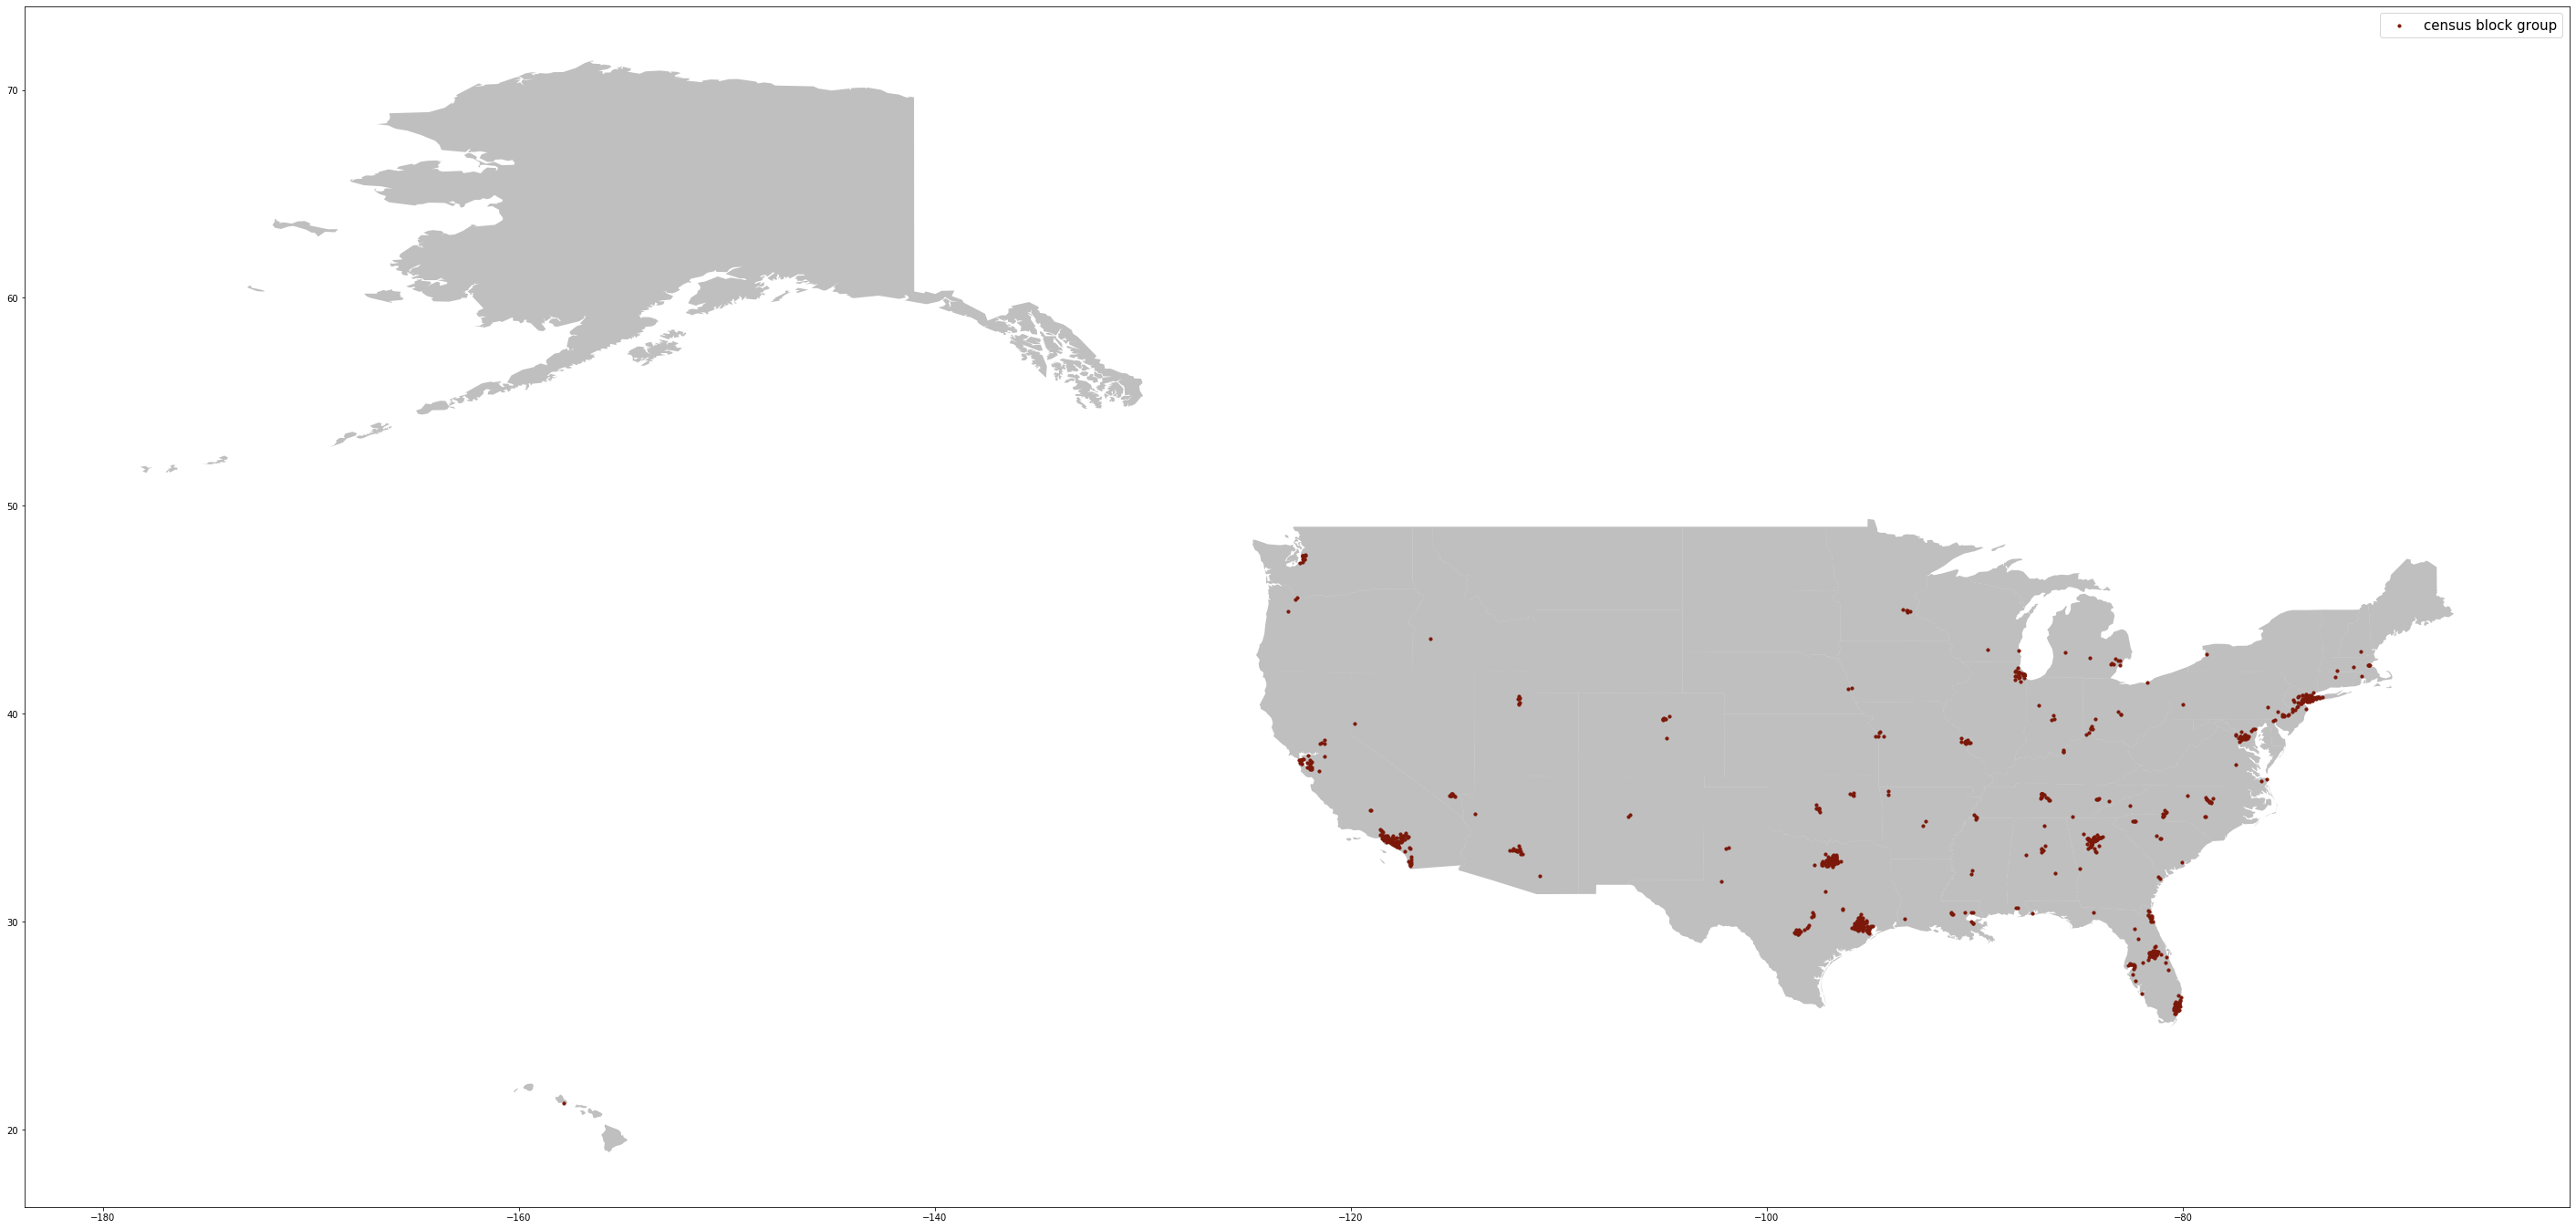

In [26]:
#First argument is the number of cbgs (top 1000 in this case) to be plotted
#column_name is the name of the column which we will sort by the dataset. In this case 'raw visitor count'
#geo_data is the dataframe containing cbg ket, latitude and longitude in the format needed to be plotted
#10 is the size of the dotis in the map
plot_most_popular_cbgs_in_map(1000,column_name,geo_data,10)

 <b>Plot top 10 cbgs in map (raw visit count)</b>

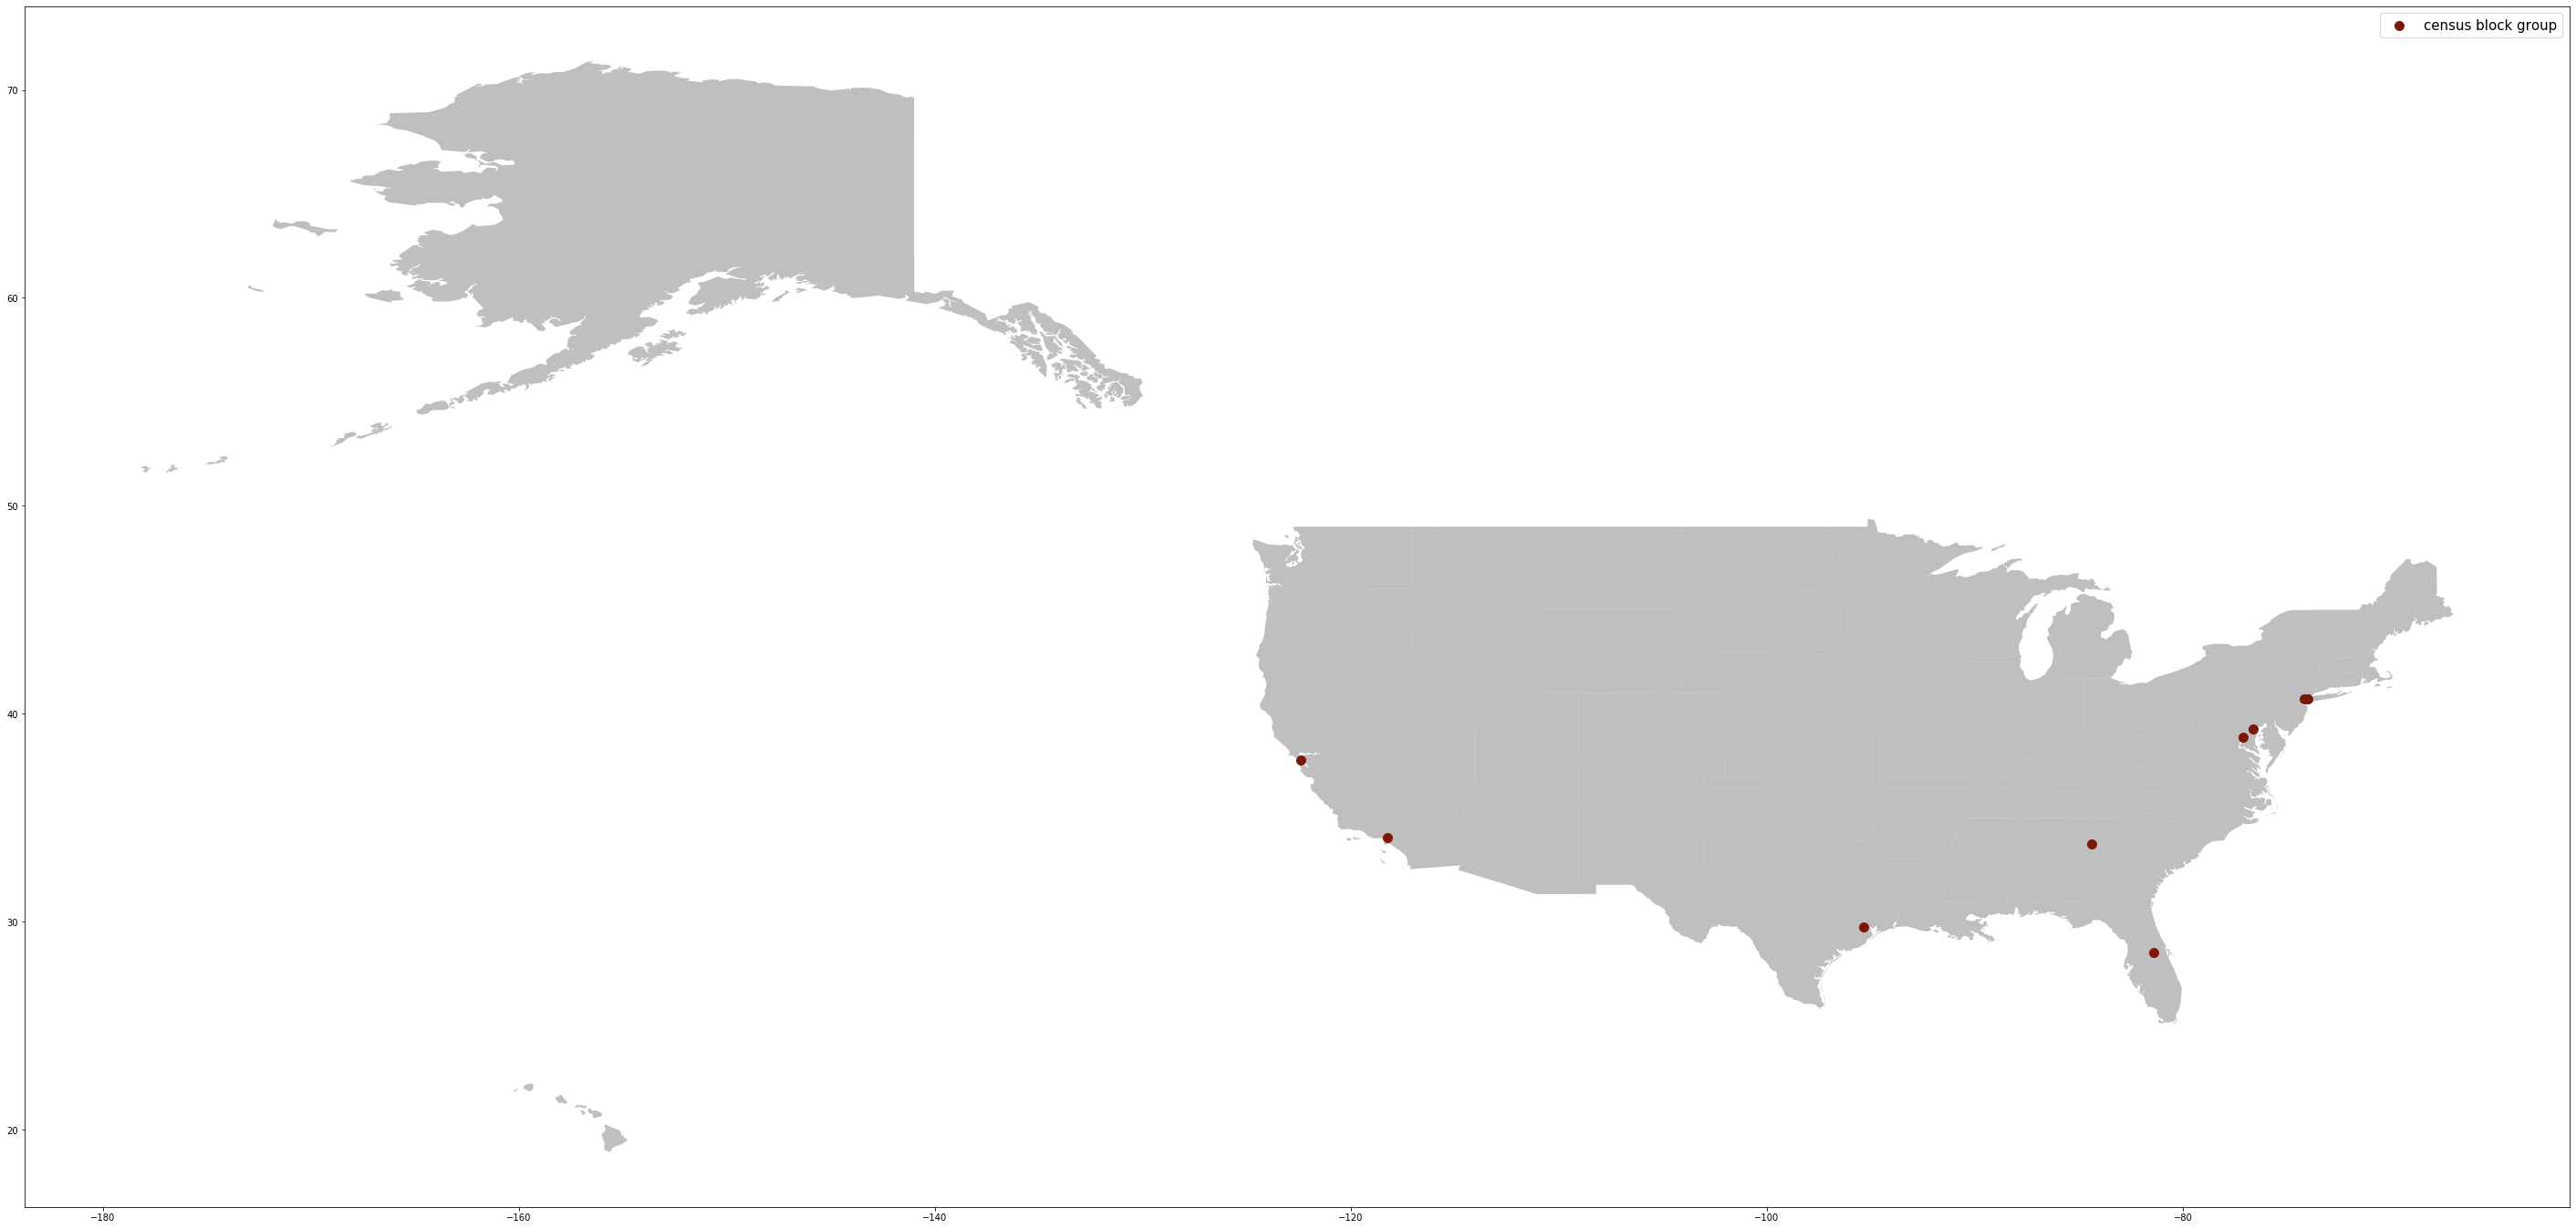

In [27]:
plot_most_popular_cbgs_in_map(10,column_name,geo_data,100)

 <p>List of top 10 cbgs in dataset (raw visitor count)</p>

In [28]:
get_most_popular_cbgs(10,column_name)

140673    360610031001
120193    060372074001
80687     482011000003
60863     340130081001
52183     131210035001
125123    245100401001
64889     060750201001
57430     510131020021
43607     120950189005
Name: census_block_group, dtype: object

# Step 4: create high level histograms of the popularity by day and hour

<b>4.1 Plot popularity of days of the week</b>

<p>First, get the sum of all days of the week in common3</p>

In [29]:
#Gets the total amount of visits in all cbgs for every day of the week (common3[week_list].sum) 
#and formats it to work with plot methods (.tolist())
#skips Nan values to avoid doing unnecesary calculations
week_sum = common3[week_list].sum(axis = 0, skipna = True).tolist()

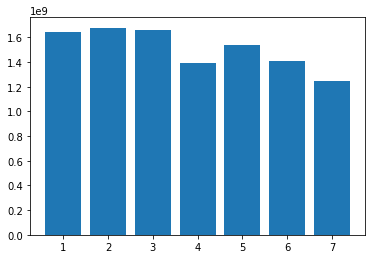

In [30]:
#Plots the histogram where a bar is the total amount of visits of a day (In x axis 1 is Monday, 2 is Tueday, etc)
plot = plt.bar(range(1,8), height = week_sum) #range(1,8) gives the amount of bars to be plotted (7)
                                              #height is the value of each bar in y  
plt.show()

<b> Interpretation: </b> across all CBGs, the most number of visits is on Tuesday, the least on Sunday. 

<b>4.2 Plot popularity of hours in a day</b>

In [31]:
#The same logic that was used in the last lines
hour_sum = common3[hour_list].sum(axis = 0 ,skipna = True).tolist()

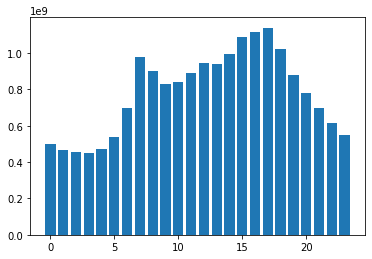

In [32]:
plot = plt.bar(range(0,24), height = hour_sum) 
plt.show()

<b> Interpretation: </b> across all CBGs, the most number of visits is at 17h, the least at 3am. 

# Step 5: plot top x cbgs (with the number x given)

In [236]:
# count on "raw_visit_count" column
def plot_most_popular_cbgs_in_hist(number,column_name):
    
    cbg_list = common3[['census_block_group',column_name]]#Gets dataframe with dataframe and the column to compare the amount of visits from
    cbg_list = cbg_list.sort_values(by = column_name, ascending = False)#Sort the values in dataframe 
    height =  cbg_list[column_name].iloc[0:number].tolist()# Get only the top x values we need
    
    plt.bar(range(1,number + 1), height = height) # Plot the hist

<b>Top 10</b>

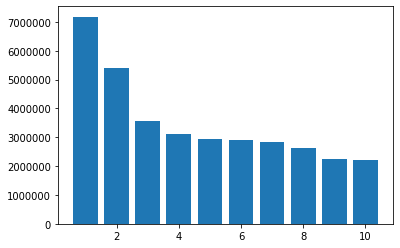

In [34]:
#The first parameter is the number of top cbgs we want to find
#The second is the column we will use to get the visits of each cbg
plot_most_popular_cbgs_in_hist(10,column_name)

<b> Interpretation: </b> there is a big difference between the 2 or 3 first CBGs and the rest. 

<b>Top 20</b>

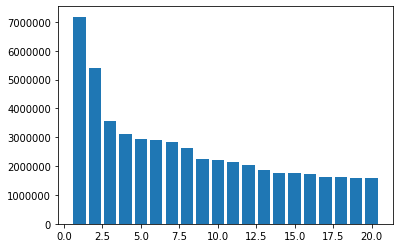

In [35]:
plot_most_popular_cbgs_in_hist(20,column_name)

<b> Interpretation: </b> the difference between the 2 or 3 first CBGs and the rest identified above is confirmed. 

<b>Top 100</b>

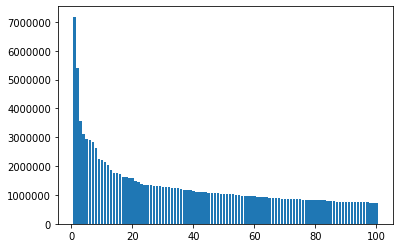

In [36]:
plot_most_popular_cbgs_in_hist(100,column_name)

<p>Top 500</p>

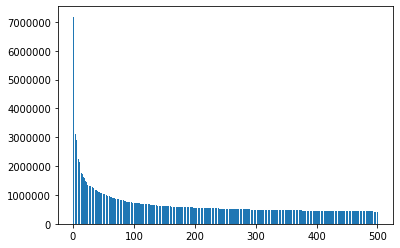

In [37]:
plot_most_popular_cbgs_in_hist(500,column_name)

<p>Top 1000</p>

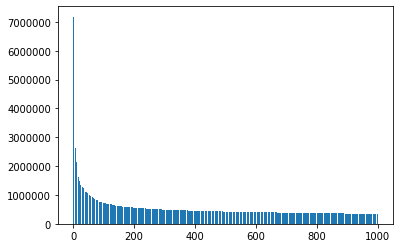

In [38]:
plot_most_popular_cbgs_in_hist(1000,column_name)

# Step 6: day classification

<b>6.1 Divide days in categories (week days and weekends)</b>
<p>First find cbgs where the most popular day is Monday</p>

In [39]:
#week_list has a list of all days of the week
# we will append census block group because it's needed to make operations
week_list_with_cbg = ['census_block_group'] + week_list

In [40]:
weekday_list = list()
weekend_list = list()

In [41]:
week_days = week_list[0:4]#Gets days from Monday to Thursday
weekend_days = week_list[4:7]#Gets days from Friday to Sunday

In [42]:
week_days

['Monday', 'Tuesday', 'Wednesday', 'Thursday']

In [43]:
common3[week_list].head()

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,12000,12224,10626,9923,12116,9516,8717
1,12125,12984,12712,11270,14922,17203,14433
2,2314,2340,2195,1841,2076,1707,1536
3,21141,21143,17546,16578,19793,17794,14174
4,8402,8414,8550,6964,7633,5993,5497


In [44]:
def max_in_weekday(row):
    return row.idxmax(axis = 1) in week_days 
#So this methods has to parts:
#First it finds the element of the row where the highest value is (row.idxmax())
#Axis  = 1 means it will return the name of the column where the element was found and not the element itself
#Next we compare if that value is in the list of week_days (from Monday to Thursday)
#Then return True or False given the result of that operation


In [45]:
for index,value in common3[week_list_with_cbg].iterrows():#Iterrows() allows to iterate over every row in a dataframe
                                                          #values is the row itself (cbg columb, monday to friday visits columns)
                                                          #index is the index in the datafram (0,1,2,etc)
    if max_in_weekday(value[1:8].astype(int)):#if the highest value of the row is in a weekday
                                              #astype(int) is only formatting necessary to make operations
        weekday_list.append(value[0])#We append the value to the list of cbgs where the highest visitor count is in a weekday
        
    

In [46]:
len(weekday_list)

188254

<b> Interpretation: </b> 188'254 is the nb of cbgs where the highest amount of visitors is between Monday and Thursday. 

In [47]:
#To obtain the list of cbgs where the highest visitor count is in a weekend day 
#We only have to find which values are not in the weekday cbg dataset (.difference())
weekend_list = list(set(common3['census_block_group']).difference(set(weekday_list)))

In [48]:
len(weekend_list)

31986

<b> Interpretation: </b> 31'986 is the nb of cbgs where the highest amount of visitors is between Friday and Sunday. Total = 220 240 OK

<b> Create dataframe with all column information for the two groups: weekday and weekend</b>

In [49]:
#Gets rows from main dataset where highest visitor count is in weekdays
weekday_df = common3[common3['census_block_group'].isin(set(weekday_list))]

In [50]:
#Gets rows from main dataset where highest visitor count is in weekend days
weekend_df = common3[common3['census_block_group'].isin(set(weekend_list))]

In [51]:
#Detail if every column in the dataset recently created
weekday_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188254 entries, 0 to 220239
Data columns (total 82 columns):
Unnamed: 0                    188254 non-null int64
census_block_group            188254 non-null object
raw_visit_count               188254 non-null float64
raw_visitor_count             188254 non-null float64
distance_from_home            188217 non-null float64
related_same_day_brand        188254 non-null object
related_same_month_brand      188254 non-null object
top_brands                    188254 non-null object
latitude                      188254 non-null float64
longitude                     188254 non-null float64
12am                          188254 non-null float64
1am                           188254 non-null float64
2am                           188254 non-null float64
3am                           188254 non-null float64
4am                           188254 non-null float64
5am                           188254 non-null float64
6am                           1

In [237]:
weekday_df.head()

,Unnamed: 0,census_block_group,raw_visit_count,raw_visitor_count,distance_from_home,related_same_day_brand,related_same_month_brand,top_brands,latitude,longitude,...,visitor_home_cbgs,vis_home_cbgs_count,vis_home_most_visits_from,vis_home_least_visits_from,avg_vis_home_visitors,visitor_work_cbgs,vis_work_cbgs_count,vis_work_most_visits_from,vis_work_least_visits_from,avg_vis_work_visitors
0,0,010059508001,75122.0,18314.0,194724.0,"[chick-fil-a, mcdonalds, marathonpetroleum, wa...","[walmart, mcdonalds, dollargeneral, chick-fil-...","[crossfit, healthmart, coldwellbanker]",31.920410,-85.175741,...,"{'010059501003': 127, '010059509001': 111, '01...",14,1.005950e+10,1.067030e+10,76.285714,"{'010059501003': 109, '010810407002': 62, '010...",4,1.005950e+10,1.069040e+10,70.000000
2,2,010479572002,14009.0,3039.0,67774.0,[dollargeneral],"[walmart, dollargeneral, mcdonalds, chevron, s...",[dollargeneral],32.357337,-87.014004,...,"{'010479567011': 67, '010479567021': 60}",2,1.047957e+10,1.047957e+10,63.500000,{'010479567021': 52},1,1.047957e+10,1.047957e+10,52.000000
3,3,010690404001,128169.0,25418.0,42684.0,"[chick-fil-a, samsclub, dollargeneral, walmart]","[walmart, dollargeneral, mcdonalds, marathonpe...","[chick-fil-a, samsclub, olivegarden, mcdonalds...",31.237327,-85.426331,...,"{'010690402013': 370, '010690402011': 322, '01...",92,1.069040e+10,1.069040e+10,99.000000,"{'010690402024': 313, '010690415004': 203, '01...",23,1.069040e+10,1.031011e+10,108.173913
4,4,010730112101,51453.0,9499.0,18878.0,"[chevron, daylightdonuts, walmart]","[walmart, chevron, dollargeneral, shelloil, ja...","[chevron, crossfit]",33.671800,-86.690610,...,"{'010090507001': 183, '010730113021': 167, '01...",37,1.009051e+10,1.073012e+10,81.513514,"{'010730045001': 140, '010730027001': 123, '01...",10,1.073005e+10,1.073002e+10,86.500000
5,5,010970063022,152557.0,23556.0,40327.0,[walmart],"[walmart, shelloil, dollargeneral, mcdonalds, ...","[walmart, winndixie, olliesbargainoutlet, soni...",30.769886,-88.245374,...,"{'010970063011': 370, '010970063021': 351, '01...",53,1.097006e+10,2.808903e+11,121.679245,"{'010970063011': 328, '010970064023': 125, '01...",15,1.097006e+10,2.803500e+11,101.333333


<b>6.2 Top 10 brands in weekday</b>

<p>Now we can compare differences of top brands between categories</p>

In [52]:
#Find top x brands of every column related to brands in weekdays dataset
brands_10_weekday_day = find_top_x_brands_with_vals(weekday_df['related_same_day_brand'],10)
brands_10_weekday_month = find_top_x_brands_with_vals(weekday_df['related_same_month_brand'],10)
brands_10_weekday_all = find_top_x_brands_with_vals(weekday_df['top_brands'],10)

In [53]:
brands_10_weekday_day
#Uncomment these lines to see the result of the other brand columns
#brands_10_weekday_month
#brands_10_weekday_all

[('walmart', 35970),
 ('mcdonalds', 34729),
 ('dunkindonuts', 18912),
 ('dollargeneral', 13761),
 ('starbucks', 12276),
 ('quiktrip', 8877),
 ('7-elevenus', 8592),
 ('wawa', 8083),
 ('sonic', 7776),
 ('shelloil', 7514)]

<b> Interpretation:</b> Walmart appears in 35 970 rows/cbg in the column "related_same_day_brand" in the dataframe "weekday_df"

In [238]:
brands_10_weekday_month

[('mcdonalds', 175741),
 ('walmart', 136252),
 ('subway', 82778),
 ('starbucks', 79475),
 ('shelloil', 61973),
 ('target', 49145),
 ('dollargeneral', 48077),
 ('dunkindonuts', 46595),
 ('walgreens', 45704),
 ('7-elevenus', 41609)]

<b> Interpretation:</b> McDonalds appears in 175 741 rows/cbg in the column "related_same_month_brand" in the dataframe "weekday_df"

In [239]:
brands_10_weekday_all

[('unitedstatespostalservice(usps)', 14979),
 ('subway', 13829),
 ('mcdonalds', 10505),
 ('dollargeneral', 10332),
 ('cricketwireless', 9501),
 ('shelloil', 8927),
 ('starbucks', 7160),
 ('familydollarstores', 6640),
 ('walgreens', 6433),
 ('cvs', 6305)]

<b> Interpretation:</b> United States Postal Service (USPS) appears in 14 979 rows/cbg in the column "top_brands" in the dataframe "weekday_df"

<b>6.3 Top 10 brands in weekend</b>

In [54]:
#Find top x brands of every column related to brands in weekend days dataset

brands_10_weekend_day = find_top_x_brands_with_vals(weekend_df['related_same_day_brand'],10)
brands_10_weekend_month = find_top_x_brands_with_vals(weekend_df['related_same_month_brand'],10)
brands_10_weekend_all = find_top_x_brands_with_vals(weekend_df['top_brands'],10)

In [55]:
brands_10_weekend_day
#brands_10_weekend_month
#brands_10_weekend_all

[('mcdonalds', 11728),
 ('walmart', 7372),
 ('pilottravelcenters', 5495),
 ('shelloil', 5116),
 ('dollargeneral', 4023),
 ('caseysgeneralstores', 2847),
 ('exxonmobil', 2656),
 ('subway', 2602),
 ('chevron', 2574),
 ('sonic', 2421)]

<b> Interpretation:</b> McDonalds appears in 11 728 rows/cbg in the column "related_same_day_brand" in the dataframe "weekend_df"

In [240]:
brands_10_weekend_month

[('mcdonalds', 30697),
 ('walmart', 28095),
 ('subway', 22077),
 ('shelloil', 16007),
 ('dollargeneral', 12947),
 ('starbucks', 10191),
 ('chick-fil-a', 8263),
 ('wendys', 8123),
 ('bp', 7541),
 ('exxonmobil', 7287)]

<b> Interpretation:</b> McDonalds appears in 30 697 rows/cbg in the column "related_same_month_brand" in the dataframe "weekend_df"

In [241]:
brands_10_weekend_all

[('unitedstatespostalservice(usps)', 7140),
 ('dollargeneral', 3183),
 ('subway', 2769),
 ('mcdonalds', 2165),
 ('shelloil', 2013),
 ('theamericanlegion', 1780),
 ('exxonmobil', 1136),
 ('bp', 1084),
 ('familydollarstores', 1018),
 ('chevron', 982)]

<b> Interpretation:</b> United States Postal Service (USPS) appears in 7 140 rows/cbg in the column "top_brands" in the dataframe "weekend_df"

# Step 7: hour classification

<b>7.1 Divide hours in categories (early morning, morning, afternoon, night)</b>
<b>Now, divide hours in categories (morning, evening, etc)</b>

In [56]:
#The process with the hours is very similar to the process with week days and weekend days
hour_list_with_cbg = ['census_block_group'] + hour_list

In [57]:
df_hours = common3[hour_list_with_cbg]

In [58]:
morning_list = list()
afternoon_list = list()
evening_list = list()
early_morning_list = list()

In [59]:
early_morning_hours =hour_list_with_cbg[slice(2,8)]
morning_hours = hour_list_with_cbg[slice(8,14)]
afternoon_hours = hour_list_with_cbg[slice(14,20)]
evening_hours = hour_list_with_cbg[slice(20,26)] + ['12am']

In [60]:
morning_hours

['7am', '8am', '9am', '10am', '11am', '12pm']

In [61]:
afternoon_hours

['1pm', '2pm', '3pm', '4pm', '5pm', '6pm']

In [62]:
evening_hours

['7pm', '8pm', '9pm', '10pm', '11pm', '12am']

In [63]:
early_morning_hours

['1am', '2am', '3am', '4am', '5am', '6am']

In [64]:
common3[hour_list].iloc[-5:]

,12am,1am,2am,3am,4am,5am,6am,7am,8am,9am,...,2pm,3pm,4pm,5pm,6pm,7pm,8pm,9pm,10pm,11pm
220235,7681.0,7249.0,7186.0,7257.0,7943.0,9488.0,12276.0,15299.0,10973.0,10082.0,...,12055.0,15158.0,16492.0,15888.0,12940.0,10752.0,10014.0,9582.0,8969.0,8207.0
220236,1404.0,1452.0,1336.0,1352.0,1482.0,1800.0,3181.0,3567.0,2895.0,2610.0,...,3819.0,4544.0,4487.0,4674.0,4129.0,3343.0,2721.0,2420.0,1855.0,1599.0
220237,758.0,735.0,735.0,749.0,760.0,764.0,860.0,1068.0,1203.0,1210.0,...,1262.0,1306.0,1178.0,1095.0,943.0,886.0,882.0,854.0,824.0,809.0
220238,364.0,350.0,358.0,368.0,368.0,360.0,400.0,358.0,359.0,343.0,...,312.0,336.0,391.0,429.0,409.0,393.0,407.0,432.0,399.0,392.0
220239,599.0,587.0,563.0,574.0,557.0,542.0,588.0,764.0,793.0,685.0,...,791.0,986.0,873.0,924.0,924.0,872.0,764.0,750.0,692.0,620.0


In [65]:
def max_in_timeframe(row,timeframe):
    return row.idxmax(axis = 1) in timeframe

In [66]:
def cbg_list_for_max(timeframe,dataframe):
    elem_list = list()
    for index,value in dataframe.iterrows():
        if max_in_timeframe(value[1:25].astype(int),timeframe):
            elem_list.append(value[0])
    return elem_list

In [67]:
morning_list = cbg_list_for_max(morning_hours,common3[hour_list_with_cbg])

In [68]:
len(morning_list)

47184

In [69]:
afternoon_list = cbg_list_for_max(afternoon_hours,common3[hour_list_with_cbg])

In [70]:
len(afternoon_list)

164404

In [71]:
evening_list = cbg_list_for_max(evening_hours,common3[hour_list_with_cbg])

In [72]:
len(evening_list)

5866

In [73]:
early_morning_list = cbg_list_for_max(early_morning_hours,common3[hour_list_with_cbg])

In [74]:
len(early_morning_list)

2786

In [75]:
#Find rows from main dataset where the cbgs has the highest visit count in the morning
morning_df = common3[common3['census_block_group'].isin(set(morning_list))]

In [76]:
morning_df.head()

,Unnamed: 0,census_block_group,raw_visit_count,raw_visitor_count,distance_from_home,related_same_day_brand,related_same_month_brand,top_brands,latitude,longitude,...,visitor_home_cbgs,vis_home_cbgs_count,vis_home_most_visits_from,vis_home_least_visits_from,avg_vis_home_visitors,visitor_work_cbgs,vis_work_cbgs_count,vis_work_most_visits_from,vis_work_least_visits_from,avg_vis_work_visitors
2,2,010479572002,14009.0,3039.0,67774.0,[dollargeneral],"[walmart, dollargeneral, mcdonalds, chevron, s...",[dollargeneral],32.357337,-87.014004,...,"{'010479567011': 67, '010479567021': 60}",2,1.047957e+10,1.047957e+10,63.500000,{'010479567021': 52},1,1.047957e+10,1.047957e+10,52.000000
3,3,010690404001,128169.0,25418.0,42684.0,"[chick-fil-a, samsclub, dollargeneral, walmart]","[walmart, dollargeneral, mcdonalds, marathonpe...","[chick-fil-a, samsclub, olivegarden, mcdonalds...",31.237327,-85.426331,...,"{'010690402013': 370, '010690402011': 322, '01...",92,1.069040e+10,1.069040e+10,99.000000,"{'010690402024': 313, '010690415004': 203, '01...",23,1.069040e+10,1.031011e+10,108.173913
17,17,050434904001,43543.0,5447.0,53432.0,"[walmart, sonic, valeroenergy, mcdonalds, stag...","[walmart, sonic, mcdonalds, dollargeneral, val...",[valeroenergy],33.579105,-91.737867,...,"{'050434903001': 152, '050434905003': 103, '05...",10,5.043490e+10,5.003960e+10,78.000000,"{'050434903001': 293, '050039603004': 86, '050...",5,5.043490e+10,5.043490e+10,113.800000
20,20,051450708003,206500.0,40699.0,62920.0,"[chick-fil-a, giorgioarmani, walmart, einstein...","[sonic, walmart, dollargeneral, valeroenergy, ...","[chick-fil-a, einsteinbrothers, pandaexpress, ...",35.228460,-91.728423,...,"{'051450709004': 286, '051450704012': 280, '05...",47,5.145071e+10,5.067481e+10,102.425532,"{'051450708001': 203, '051450712002': 138, '05...",15,5.145071e+10,5.119004e+10,99.733333
21,21,060014359004,14981.0,2332.0,6356.0,[costcowholesalecorp.],"[costcowholesalecorp., chevron, mcdonalds, sta...",[],37.674091,-122.145896,...,"{'060014359003': 58, '060014359001': 56, '0600...",3,6.001436e+10,6.001436e+10,55.666667,{'060014359001': 83},1,6.001436e+10,6.001436e+10,83.000000


In [77]:
#Find rows from main dataset where the cbgs has the highest visit count in the afternoon

afternoon_df = common3[common3['census_block_group'].isin(set(afternoon_list))]

In [78]:
#Find rows from main dataset where the cbgs has the highest visit count in the evening

evening_df = common3[common3['census_block_group'].isin(set(evening_list))]

In [79]:
#Find rows from main dataset where the cbgs has the highest visit count in the early morning

early_morning_df = common3[common3['census_block_group'].isin(set(early_morning_list))]

<b>7.2 Top 10 brands in early morning </b>

In [86]:
brands_10_early_morning_day = find_top_x_brands_with_vals(early_morning_df['related_same_day_brand'],10)
brands_10_early_morning_month = find_top_x_brands_with_vals(early_morning_df['related_same_month_brand'],10)
brands_10_early_morning_all = find_top_x_brands_with_vals(early_morning_df['top_brands'],10)

In [87]:
brands_10_early_morning_all

[('unitedstatespostalservice(usps)', 415),
 ('dollargeneral', 87),
 ('aflac(americanfamilylifeassurance)', 80),
 ('theamericanlegion', 69),
 ('shelloil', 51),
 ('vfw(veteransofforeignwars)', 38),
 ('cricketwireless', 35),
 ('familydollarstores', 31),
 ('subway', 29),
 ('marathonpetroleum', 29)]

<b> Interpretation:</b> United States Postal Service (USPS) appears in 415 rows/cbg in the column "top_brands" in the dataframe "early_morning_df"

In [248]:
brands_10_early_morning_day

[('walmart', 627),
 ('mcdonalds', 594),
 ('dollargeneral', 410),
 ('dunkindonuts', 294),
 ('shelloil', 216),
 ('7-elevenus', 209),
 ('sheetz', 185),
 ('familydollarstores', 179),
 ('unitedstatespostalservice(usps)', 173),
 ('exxonmobil', 156)]

<b> Interpretation:</b> Walmart appears in 627 rows/cbg in the column "related_same_day_brand" in the dataframe "early_morning_df"

In [249]:
brands_10_early_morning_month

[('mcdonalds', 2129),
 ('walmart', 1905),
 ('dollargeneral', 933),
 ('shelloil', 859),
 ('subway', 740),
 ('dunkindonuts', 615),
 ('starbucks', 549),
 ('walgreens', 531),
 ('exxonmobil', 512),
 ('chevron', 486)]

<b> Interpretation:</b> McDonalds appears in 2129 rows/cbg in the column "related_same_month_brand" in the dataframe "early_morning_df"

<b>Top 10 brands in morning </b>

In [80]:
#Find top x brands of every column related to brands in morning dataset

brands_10_morning_day = find_top_x_brands_with_vals(morning_df['related_same_day_brand'],10)
brands_10_morning_month = find_top_x_brands_with_vals(morning_df['related_same_month_brand'],10)
brands_10_morning_all = find_top_x_brands_with_vals(morning_df['top_brands'],10)

In [81]:
brands_10_morning_all

[('unitedstatespostalservice(usps)', 4368),
 ('subway', 2728),
 ('dollargeneral', 2230),
 ('mcdonalds', 1594),
 ('shelloil', 1573),
 ('theamericanlegion', 1421),
 ('cricketwireless', 1418),
 ('familydollarstores', 1212),
 ('starbucks', 1178),
 ('aflac(americanfamilylifeassurance)', 1136)]

<b> Interpretation:</b> United States Postal Service (USPS) appears in 4368 rows/cbg in the column "top_brands" in the dataframe "morning_df"

In [242]:
brands_10_morning_day

[('walmart', 8837),
 ('mcdonalds', 7874),
 ('dunkindonuts', 4969),
 ('dollargeneral', 4197),
 ('starbucks', 3491),
 ('shelloil', 2456),
 ('sonic', 2455),
 ('circlekstores', 1872),
 ('7-elevenus', 1864),
 ('chick-fil-a', 1735)]

<b> Interpretation:</b> Walmart appears in 8837 rows/cbg in the column "related_same_day_brand" in the dataframe "morning_df"

In [243]:
brands_10_morning_month

[('mcdonalds', 42936),
 ('walmart', 31491),
 ('subway', 20657),
 ('starbucks', 20491),
 ('shelloil', 16011),
 ('dollargeneral', 12452),
 ('target', 12068),
 ('dunkindonuts', 11882),
 ('chevron', 11314),
 ('7-elevenus', 10532)]

<b> Interpretation:</b> McDonalds appears in 42 936 rows/cbg in the column "related_same_month_brand" in the dataframe "morning_df"

<b>Top 10 brands in afternoon </b>

In [82]:
brands_10_afternoon_day = find_top_x_brands_with_vals(afternoon_df['related_same_day_brand'],10)
brands_10_afternoon_month = find_top_x_brands_with_vals(afternoon_df['related_same_month_brand'],10)
brands_10_afternoon_all = find_top_x_brands_with_vals(afternoon_df['top_brands'],10)

In [83]:
brands_10_afternoon_all

[('unitedstatespostalservice(usps)', 16877),
 ('subway', 13764),
 ('dollargeneral', 11107),
 ('mcdonalds', 11027),
 ('shelloil', 9268),
 ('cricketwireless', 8597),
 ('starbucks', 6860),
 ('familydollarstores', 6344),
 ('walgreens', 6054),
 ('cvs', 5998)]

<b> Interpretation:</b> United States Postal Service (USPS) appears in 16 877 rows/cbg in the column "top_brands" in the dataframe "afternoon_df"

In [244]:
brands_10_afternoon_day

[('mcdonalds', 37013),
 ('walmart', 32813),
 ('dunkindonuts', 15173),
 ('dollargeneral', 12608),
 ('starbucks', 9732),
 ('shelloil', 9677),
 ('quiktrip', 7963),
 ('pilottravelcenters', 7753),
 ('sonic', 7472),
 ('speedway', 7388)]

<b> Interpretation:</b> McDonalds appears in 37 013 rows/cbg in the column "related_same_day_brand" in the dataframe "afternoon_df"

In [245]:
brands_10_afternoon_month

[('mcdonalds', 157181),
 ('walmart', 127836),
 ('subway', 81747),
 ('starbucks', 67033),
 ('shelloil', 59759),
 ('dollargeneral', 46399),
 ('target', 41299),
 ('walgreens', 38578),
 ('dunkindonuts', 37999),
 ('chick-fil-a', 36676)]

<b> Interpretation:</b> McDonalds appears in 157 181 rows/cbg in the column "related_same_month_brand" in the dataframe "afternoon_df"

<b>Top 10 brands in evening </b>

In [84]:
brands_10_evening_day = find_top_x_brands_with_vals(evening_df['related_same_day_brand'],10)
brands_10_evening_month = find_top_x_brands_with_vals(evening_df['related_same_month_brand'],10)
brands_10_evening_all = find_top_x_brands_with_vals(evening_df['top_brands'],10)

In [85]:
brands_10_evening_all

[('unitedstatespostalservice(usps)', 459),
 ('cricketwireless', 145),
 ('theamericanlegion', 117),
 ('dollargeneral', 91),
 ('aflac(americanfamilylifeassurance)', 83),
 ('subway', 77),
 ('familydollarstores', 71),
 ('nationalassociationfortheeducationofyoungchildren(naeyc)', 64),
 ('vfw(veteransofforeignwars)', 60),
 ('boys&girlsclubsofamerica', 49)]

<b> Interpretation:</b> United States Postal Service (USPS) appears in 459 rows/cbg in the column "top_brands" in the dataframe "evening_df"

In [246]:
brands_10_evening_day

[('walmart', 1065),
 ('mcdonalds', 976),
 ('dollargeneral', 569),
 ('dunkindonuts', 536),
 ('familydollarstores', 490),
 ('7-elevenus', 376),
 ('starbucks', 305),
 ('shelloil', 281),
 ('chevron', 250),
 ('unitedstatespostalservice(usps)', 225)]

<b> Interpretation:</b> Walmart appears in 1 065 rows/cbg in the column "related_same_day_brand" in the dataframe "evening_df"

In [247]:
brands_10_evening_month

[('mcdonalds', 4192),
 ('walmart', 3115),
 ('subway', 1711),
 ('starbucks', 1593),
 ('shelloil', 1351),
 ('dunkindonuts', 1283),
 ('chevron', 1261),
 ('7-elevenus', 1244),
 ('dollargeneral', 1240),
 ('familydollarstores', 1239)]

<b> Interpretation:</b> McDonalds appears in 4 192 rows/cbg in the column "related_same_month_brand" in the dataframe "evening_df"

#  Data Clustering


<p>Implementation with OPTICS algorithm</p>


In [88]:
import time
from math import radians, cos, sin, atan2, sqrt


In [89]:
cbg_w_coordinates.head()    

,census_block_group,latitude,longitude,geometry
0,010059508001,31.920410,-85.175741,POINT (-85.17574090000002 31.92041)
1,010090506011,33.863884,-86.903514,POINT (-86.9035142 33.8638835)
2,010479572002,32.357337,-87.014004,POINT (-87.0140035 32.3573365)
3,010690404001,31.237327,-85.426331,POINT (-85.4263314 31.2373273)
4,010730112101,33.671800,-86.690610,POINT (-86.69061020000002 33.6717999)


In [90]:
EARTH_RADIO = 6371e3; 
#haversine distance is a mathematical function to find the shortest distance between two points in an sphere
#You can find a highly more detailed explanation in https://www.movable-type.co.uk/scripts/latlong.html
#Several optimizations have been made, eg. using math library instead of numpy to save execution time
#also using multiplication with 0.5 instead of dividing by 2, since division is about 6 times slower for computers
#Passing the values of latitude directly in radians to avoid that extra calculation inside the method, etc
def haversine_distance(point1,point2):
    
    phi1 = point1[0]
    phi2 = point2[0]
    delta_phi = point2[0] - point1[0]
    delta_lambda = point2[1] - point1[1]
    a = (sin(delta_phi*0.5))**2 + cos(phi1)*cos(phi2)*(sin(delta_lambda*0.5))**2
    c = 2*atan2(sqrt(a),sqrt(1-a))
    
    return c #(EARTH_RADIO * c)/1000 if you want in kms

In [93]:

#haversine_distance(point1,point2)
#The value of distance it returns is small. To have sense for us we should make its conversion con km
#but for computer it's fine and it saves computing power by not doing that conversion

In [94]:
#Obtain the values needed to make the analysis and clustering
test = cbg_w_coordinates[['latitude','longitude']]
test1 = geo_data.copy()



In [95]:
#Conversion to radians to save time as explained before
test = test.apply(lambda row: np.radians(row))

In [99]:

#Min samples is the amount of 'core' points needed to be recognized as a cluster
#core points are basically points in the 'middle' (or just semi-central) of a high density zone
#Metric is the way the algorithm will measure distance. Since we are working in a 'sphere' we will use haversine 
#(although Earth is not REALLY a sphere, but the error is acceptable, about 0.3%
#Max_exps is the maximun distance the algorithm will search for neighbors for a cluster
#since the haversine function returns very small values (above the distance was 0.04, which converted is about 268 km),
#the value in this function is also really small. With 0.01 a many points that weren't noise were considered as such,
#with 0.08 it takes WAY to long to run, I suggest to lower it to 0.05 and see it the results are good enough
clust = OPTICS(min_samples = 7, metric = haversine_distance, min_cluster_size= 7, max_eps = 0.04)

In [157]:
start_time = time.time()#Line to measure the time it takes to run the algorithm
clust.fit(test)#the process of clustering itself
print("--- %s seconds ---" % (time.time() - start_time))#Also to measure time
# this line takes many hours to be executed, and made it run once and saved the file

KeyboardInterrupt: 

In [159]:
space = np.arange(test.shape[0])#array with numbers from 0 to the number of cbgs
labels = np.asarray(clust.labels_)# cluster to which the data point belongs (has the same length and index that the main dataset)
test1['Cluster'] = labels #Add the cluster labels to the dataset with all values

In [160]:
#There are 8622 clusters (from 0 to 8621, -1 is considered noise)
np.unique(labels)

array([  -1,    0,    1, ..., 5307, 5308, 5309])

In [161]:
len(np.unique(labels))

5311

In [162]:
test1.head()

,census_block_group,latitude,longitude,geometry,Cluster
0,010059508001,31.920410,-85.175741,POINT (-85.17574090000002 31.92041),0
1,010090506011,33.863884,-86.903514,POINT (-86.9035142 33.8638835),-1
2,010479572002,32.357337,-87.014004,POINT (-87.0140035 32.3573365),3424
3,010690404001,31.237327,-85.426331,POINT (-85.4263314 31.2373273),1
4,010730112101,33.671800,-86.690610,POINT (-86.69061020000002 33.6717999),-1


<p>Save the clustered dataset to a csv file</p>


In [164]:
common3 = pd.concat([common3, test1['Cluster']],axis = 1, ignore_index= False, sort=False)

In [165]:
common3.head()

,Unnamed: 0,census_block_group,raw_visit_count,raw_visitor_count,distance_from_home,related_same_day_brand,related_same_month_brand,top_brands,latitude,longitude,...,vis_home_most_visits_from,vis_home_least_visits_from,avg_vis_home_visitors,visitor_work_cbgs,vis_work_cbgs_count,vis_work_most_visits_from,vis_work_least_visits_from,avg_vis_work_visitors,Cluster,Cluster
0,0,010059508001,75122.0,18314.0,194724.0,"[chick-fil-a, mcdonalds, marathonpetroleum, wa...","[walmart, mcdonalds, dollargeneral, chick-fil-...","[crossfit, healthmart, coldwellbanker]",31.920410,-85.175741,...,1.005950e+10,1.067030e+10,76.285714,"{'010059501003': 109, '010810407002': 62, '010...",4,1.005950e+10,1.069040e+10,70.000000,0,0
1,1,010090506011,95649.0,38942.0,120587.0,"[shelloil, mcdonalds, chick-fil-a, chevron]","[walmart, mcdonalds, shelloil, chick-fil-a, do...",[],33.863884,-86.903514,...,1.073011e+10,1.009051e+10,80.623188,"{'010890111001': 271, '010730045001': 269, '01...",41,1.089011e+10,1.077011e+10,93.756098,-1,-1
2,2,010479572002,14009.0,3039.0,67774.0,[dollargeneral],"[walmart, dollargeneral, mcdonalds, chevron, s...",[dollargeneral],32.357337,-87.014004,...,1.047957e+10,1.047957e+10,63.500000,{'010479567021': 52},1,1.047957e+10,1.047957e+10,52.000000,3424,3424
3,3,010690404001,128169.0,25418.0,42684.0,"[chick-fil-a, samsclub, dollargeneral, walmart]","[walmart, dollargeneral, mcdonalds, marathonpe...","[chick-fil-a, samsclub, olivegarden, mcdonalds...",31.237327,-85.426331,...,1.069040e+10,1.069040e+10,99.000000,"{'010690402024': 313, '010690415004': 203, '01...",23,1.069040e+10,1.031011e+10,108.173913,1,1
4,4,010730112101,51453.0,9499.0,18878.0,"[chevron, daylightdonuts, walmart]","[walmart, chevron, dollargeneral, shelloil, ja...","[chevron, crossfit]",33.671800,-86.690610,...,1.009051e+10,1.073012e+10,81.513514,"{'010730045001': 140, '010730027001': 123, '01...",10,1.073005e+10,1.073002e+10,86.500000,-1,-1


In [187]:
common3.shape

(220240, 84)

In [158]:
file_path = '/Users/colinechabloz/Desktop/Datasets/EDAdatasets/'
common3_clustered = 'common3_clustered2.csv'

In [186]:
common3.to_csv(path_or_buf = (file_path + common3_clustered))

In [188]:
import random

In [189]:
def generate_colors(num):
    """This function returns a random list of colors. It is useful to plot hundreds of cbgs and make sure they 
        are distinguishable from each other"""
    return ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(num)]

In [190]:
def gen_colors_list(num):
    """Makes a color list calling to generate_colors() and then adding  white color to the beginning of the list"""
    colors_list = list()
    cbgs = list(test1['Cluster'])
    colors  = ['#FFFFFF'] + generate_colors(num - 1)# FFFFFF is white, and it will always be the color of noise
    for cbg in cbgs:
        if cbg == -1:
            colors_list.append(colors[0])
        else:
            colors_list.append(colors[cbg+1])
    return colors_list

In [191]:
def plot_clustered_cbgs_in_map(geo_data,dot_size):  
    """This method provides an easy way to plot the cbgs, the first arg is the number of cbgs, the the column (visitors per day, per week, etc), dot_size is the radio of the plotted dots"""
    cbgs_list = geo_data
    figure, ax = plt.subplots(figsize  = (50,30))
    us_map.plot(ax = ax, alpha = 0.5, color = "grey")#Plots US map
    clusters =  list(np.unique(test1['Cluster']))#Gets all unique clusters to create the colors list
    colors = gen_colors_list(len(clusters))#Create the color list
    
    #Plots the clustered cbgs over the make,  each cluster with a given color
    cbgs_list.plot(ax = ax, markersize = dot_size, color = colors, marker = "o", label = "census block group")




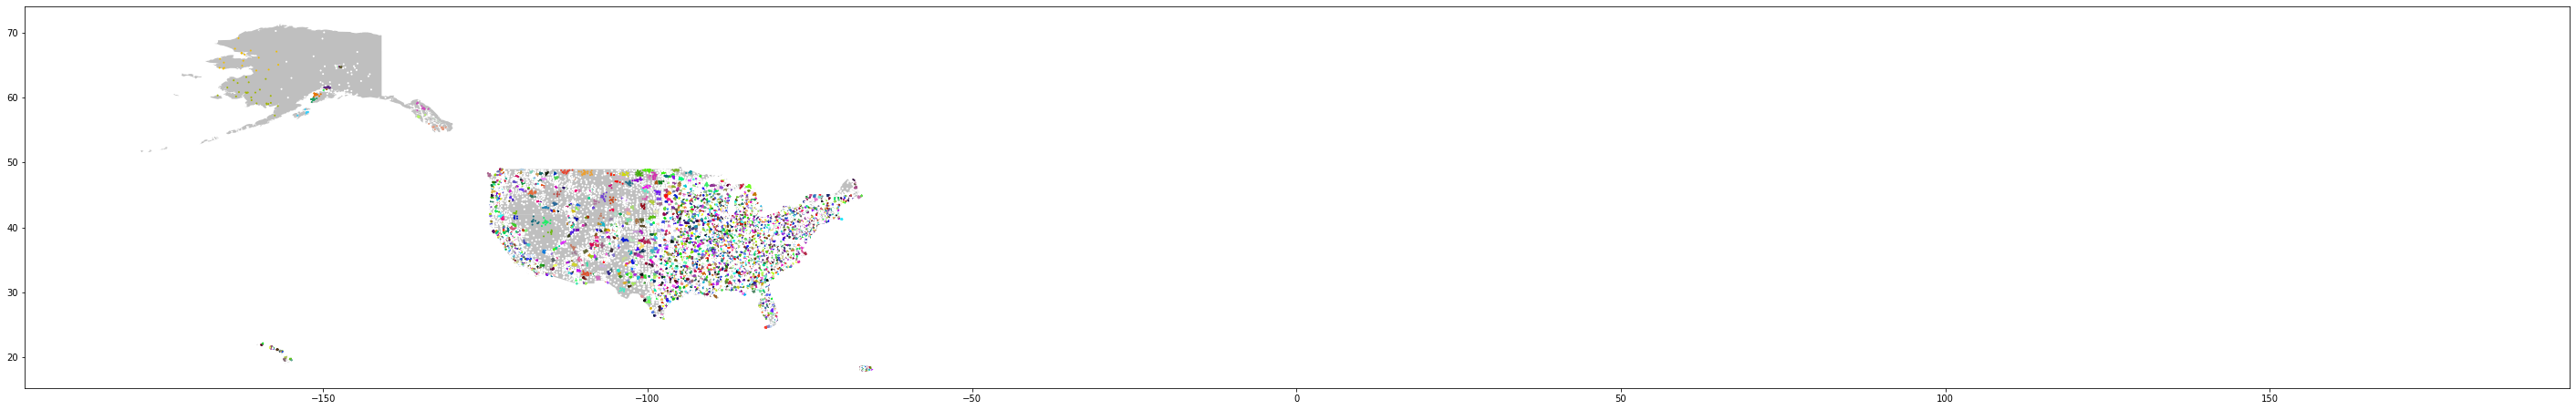

In [192]:
plot_clustered_cbgs_in_map(test1,1)

## Much faster implementation with HDBSCAN but the results are not that good
<p>Implementation with HDBSCAN algorithm</p>


In [194]:
#You shouldn't run all this section since it takes a lot of time and information obtain is not useful
#It's just an example to see an implementation of a different algorithm
import hdbscan

/Users/colinechabloz/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/colinechabloz/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [202]:
test = cbg_w_coordinates[['latitude','longitude']].iloc[0:10000] #remove .iloc... to do on full dataset
test1 = geo_data.iloc[0:10000].copy() #remove .iloc... to do on full dataset

In [203]:
#The minimun cluster size should be around ~20000 people
clusterer = hdbscan.HDBSCAN(min_cluster_size = 10, min_samples = 40, metric = haversine_distance)


In [204]:
test_hdbscan = test.apply(lambda x: np.radians(x))

In [205]:
test_hdbscan.head()

,latitude,longitude
0,0.557116,-1.486597
1,0.591036,-1.516752
2,0.564742,-1.518681
3,0.545194,-1.490971
4,0.587684,-1.513037


In [206]:
start_time = time.time()
clusterer.fit(test)
print("--- %s seconds ---" % (time.time() - start_time))

KeyboardInterrupt: 

In [ ]:
labels = np.asarray(clusterer.labels_)# cluster to which the data point belongs
test1['Cluster'] = labels

In [201]:
np.unique(labels)

array([-1,  0,  1])

In [ ]:
labels = np.asarray(clusterer.labels_)# cluster to which the data point belongs
test1['Cluster'] = labels

In [ ]:
plot_clustered_cbgs_in_map(test1,1)

### EDA with the clustered data

In [207]:
file_path = '/Users/colinechabloz/Desktop/Datasets/EDAdatasets/'
full_test_n = 'common3_clustered2.csv'

In [208]:
#Gets clustered dataset from file previously saved
full_test = pd.read_csv((file_path+full_test_n), dtype={'census_block_group':str},
                      converters={"related_same_day_brand": ast.literal_eval,
                                  "related_same_month_brand": ast.literal_eval,
                                  "top_brands" : ast.literal_eval })

In [209]:
#Deletes unnecessary columns (unnamed, which were basically a repetition of the values in the index)
full_test = full_test.loc[:, ~full_test.columns.str.match('Unnamed')]
full_test.head()

,census_block_group,raw_visit_count,raw_visitor_count,distance_from_home,related_same_day_brand,related_same_month_brand,top_brands,latitude,longitude,12am,...,vis_home_most_visits_from,vis_home_least_visits_from,avg_vis_home_visitors,visitor_work_cbgs,vis_work_cbgs_count,vis_work_most_visits_from,vis_work_least_visits_from,avg_vis_work_visitors,Cluster,Cluster.1
0,010059508001,75122.0,18314.0,194724.0,"[chick-fil-a, mcdonalds, marathonpetroleum, wa...","[walmart, mcdonalds, dollargeneral, chick-fil-...","[crossfit, healthmart, coldwellbanker]",31.920410,-85.175741,2617.0,...,1.005950e+10,1.067030e+10,76.285714,"{'010059501003': 109, '010810407002': 62, '010...",4,1.005950e+10,1.069040e+10,70.000000,0,0
1,010090506011,95649.0,38942.0,120587.0,"[shelloil, mcdonalds, chick-fil-a, chevron]","[walmart, mcdonalds, shelloil, chick-fil-a, do...",[],33.863884,-86.903514,6556.0,...,1.073011e+10,1.009051e+10,80.623188,"{'010890111001': 271, '010730045001': 269, '01...",41,1.089011e+10,1.077011e+10,93.756098,-1,-1
2,010479572002,14009.0,3039.0,67774.0,[dollargeneral],"[walmart, dollargeneral, mcdonalds, chevron, s...",[dollargeneral],32.357337,-87.014004,807.0,...,1.047957e+10,1.047957e+10,63.500000,{'010479567021': 52},1,1.047957e+10,1.047957e+10,52.000000,3424,3424
3,010690404001,128169.0,25418.0,42684.0,"[chick-fil-a, samsclub, dollargeneral, walmart]","[walmart, dollargeneral, mcdonalds, marathonpe...","[chick-fil-a, samsclub, olivegarden, mcdonalds...",31.237327,-85.426331,2121.0,...,1.069040e+10,1.069040e+10,99.000000,"{'010690402024': 313, '010690415004': 203, '01...",23,1.069040e+10,1.031011e+10,108.173913,1,1
4,010730112101,51453.0,9499.0,18878.0,"[chevron, daylightdonuts, walmart]","[walmart, chevron, dollargeneral, shelloil, ja...","[chevron, crossfit]",33.671800,-86.690610,3804.0,...,1.009051e+10,1.073012e+10,81.513514,"{'010730045001': 140, '010730027001': 123, '01...",10,1.073005e+10,1.073002e+10,86.500000,-1,-1


In [210]:
#Changes the format of visitor_home_cbgs column from str to dict to work with it
%%capture
full_test['visitor_home_cbgs'] = full_test['visitor_home_cbgs'].apply(lambda elem: ast.literal_eval(elem))

UsageError: Line magic function `%%capture` not found.


In [211]:
full_test['visitor_home_cbgs'].head()

0    {'010059501003': 127, '010059509001': 111, '01...
1    {'010730113021': 210, '010090506022': 205, '01...
2             {'010479567011': 67, '010479567021': 60}
3    {'010690402013': 370, '010690402011': 322, '01...
4    {'010090507001': 183, '010730113021': 167, '01...
Name: visitor_home_cbgs, dtype: object

<head>Top 10 brands per cluster</head>


In [212]:
#Simply gets the rows corresponding to a cluster and then reuses find_top_x_brands_with_vals() method
def top_brands_cluster(dataframe, cluster,number_brands,column_name):
    dataframe = dataframe[dataframe['Cluster'] == cluster][column_name]# gets the rows
    return  find_top_x_brands_with_vals(dataframe,number_brands)

In [213]:
#full_test is the dataset we are working with
#1976 the cbg we want to analyze
#10 the amount of top brands we want to find
#top_brands the column we are analyzing
top_brands_cluster(full_test,1976,10,'top_brands')

[('cricketwireless', 3),
 ('7-elevenus', 2),
 ('ziebart', 1),
 ('cvs', 1),
 ('dunkindonuts', 1),
 ('tacobell', 1),
 ('bp', 1),
 ('boostmobile', 1),
 ('planetfitness', 1),
 ('olliesbargainoutlet', 1)]

<p>Most popular clusters</p>


In [214]:
def total_visits_to_cluster(clusters_dict,row):
    cluster  = row['Cluster']#gets the cluster column value from the received row
    visits =  row[column_name]#gets the column_name value (eg. 'raw visit count') from the received row
    if cluster in list(clusters_dict.keys()):#if the cluster has appeared before
        clusters_dict[cluster] += visits #add the visits value to the visit total in the dict
    else:                                    #if it hasn't appeared before
        clusters_dict.update({cluster : visits}) # add it to the dict with the visits from the row as value


In [215]:
def get_clusters_where_visits(criteria,clusters_num,column_name,dataframe):
    clusters_dict = dict()
    if clusters_num <= 0:
        print("Please enter a valid number of clusters")
        return
    
    if criteria == "come_to":
        dataframe = dataframe[['Cluster', column_name]]
        dataframe.apply(lambda row: total_visits_to_cluster(clusters_dict , row), axis = 1)#apply to every row
    elif criteria == "come_from":
    
        dataframe = dataframe[['census_block_group','Cluster', column_name]]
    #This part of the method used to be really slow given its nature, so the next line helps to save calculations
    #and make other caculations faster before even starting applying the funcion
    
        #First it assings cbgs as indexes of the dataframe (.set_index()) since index search is much faster than
        #searching values in a column of the dataframe
        #Then, it orders the indexes, optimizing even further the search 
        #(Unique and sorted indexes search order of complexity is very close to constant)
        #Comparing that to value search which is linear (~ O(1) vs O(n))
        dataframe = dataframe.set_index('census_block_group').sort_index()
        #Create the dict where we will save the results
        cbgs_cluster_dict = dict()
        #apply the function to every row
        dataframe.apply(lambda row: total_visits_from_cluster(clusters_dict , row ,dataframe,column_name, cbgs_cluster_dict), axis = 1)
    counter = Counter(clusters_dict)
    top_x = counter.most_common(clusters_num+1)
    return top_x

In [216]:
column_name = 'raw_visit_count'
top_10_to = get_clusters_where_visits('come_to',10,column_name, full_test)
top_10_to   #every tuple represents the number of the cluster and the total visit count for it

[(-1.0, 7503945168.0),
 (2630.0, 5098071.0),
 (116.0, 4979170.0),
 (3111.0, 4798233.0),
 (2003.0, 4680250.0),
 (2011.0, 4172008.0),
 (334.0, 4139163.0),
 (2899.0, 4098064.0),
 (2879.0, 4057375.0),
 (3548.0, 3968881.0),
 (15.0, 3954524.0)]

In [217]:
full_test1 = full_test.copy()

In [218]:

full_test1  = full_test1.set_index('census_block_group')

In [219]:
#Example of the datasets with the cbgs as indexes
full_test1.sort_index()

,raw_visit_count,raw_visitor_count,distance_from_home,related_same_day_brand,related_same_month_brand,top_brands,latitude,longitude,12am,1am,...,vis_home_most_visits_from,vis_home_least_visits_from,avg_vis_home_visitors,visitor_work_cbgs,vis_work_cbgs_count,vis_work_most_visits_from,vis_work_least_visits_from,avg_vis_work_visitors,Cluster,Cluster.1
census_block_group,,,,,,,,,,,,,,,,,,,,,
010010201001,54544.0,14460.0,45094.0,"[winndixie, chick-fil-a, walmart]","[walmart, dollargeneral, chick-fil-a, americas...",[],32.465829,-86.489614,1840.0,1666.0,...,1.001021e+10,1.001021e+10,95.130435,"{'010010208022': 233, '011250112001': 106, '01...",7,1.001021e+10,1.001021e+10,93.571429,2472,2472
010010201002,19583.0,2351.0,7346.0,"[winndixie, walmart, chick-fil-a]","[walmart, americasthriftstore, chick-fil-a, do...",[],32.485849,-86.489690,2201.0,2137.0,...,1.001021e+10,1.001021e+10,104.166667,{'010010208022': 223},1,1.001021e+10,1.001021e+10,223.000000,2472,2472
010010202001,24552.0,3020.0,6977.0,"[americasthriftstore, winndixie, chick-fil-a]","[walmart, americasthriftstore, dollargeneral, ...",[],32.480082,-86.474974,1280.0,1233.0,...,1.001021e+10,1.001020e+10,93.666667,{'010010208022': 258},1,1.001021e+10,1.001021e+10,258.000000,2472,2472
010010202002,61089.0,7123.0,13528.0,"[winndixie, walmart, americasthriftstore, chic...","[walmart, dollargeneral, chick-fil-a, mcdonald...","[alabamadmv, foxspizzaden, americasthriftstore...",32.464435,-86.469766,1518.0,1326.0,...,1.001021e+10,1.051031e+10,113.111111,"{'010010208022': 262, '011010002001': 90, '010...",8,1.001021e+10,1.001020e+10,96.500000,2472,2472
010010203001,41139.0,5132.0,11597.0,"[americasthriftstore, walmart, chick-fil-a]","[walmart, dollargeneral, mcdonalds, americasth...",[],32.480175,-86.460793,3318.0,3261.0,...,1.001021e+10,1.001020e+10,96.736842,"{'010010208022': 265, '010010209004': 66, '010...",6,1.001021e+10,1.001020e+10,92.666667,2472,2472
010010203002,91053.0,20907.0,16162.0,"[winndixie, walmart, americasthriftstore]","[americasthriftstore, dollargeneral, walmart, ...","[winndixie, planetfitness, americasthriftstore...",32.464309,-86.458472,2109.0,1738.0,...,1.001021e+10,1.051030e+10,113.694444,"{'010010208022': 278, '011010002001': 110, '01...",12,1.001021e+10,1.001021e+10,92.916667,2472,2472
010010204001,45927.0,6257.0,10672.0,"[walmart, americasthriftstore, chick-fil-a, wi...","[walmart, dollargeneral, mcdonalds, chick-fil-...","[dominospizza, farmersinsurancegroup]",32.485161,-86.444772,1557.0,1439.0,...,1.001021e+10,1.051031e+10,113.120000,"{'010010208022': 261, '010510313001': 93, '011...",8,1.001021e+10,1.001020e+10,97.125000,2472,2472
010010204002,46586.0,6428.0,10893.0,"[walmart, winndixie, americasthriftstore, chic...","[walmart, dollargeneral, mcdonalds, chick-fil-...",[],32.470438,-86.435969,3479.0,3337.0,...,1.001021e+10,1.051031e+10,109.923077,"{'010010208022': 267, '010510313001': 97, '011...",8,1.001021e+10,1.001020e+10,99.625000,2472,2472
010010204003,35914.0,6349.0,11506.0,"[walmart, tacobell, americasthriftstore, winnd...","[walmart, dollargeneral, mcdonalds, americasth...","[tacobell, themedicineshoppe, papajohns, subwa...",32.463222,-86.444280,1606.0,1454.0,...,1.001021e+10,1.051031e+10,110.884615,"{'010010208022': 259, '011010002001': 92, '010...",7,1.001021e+10,1.051031e+10,103.571429,2472,2472


<p>Top 10 clusters where people visit from </p>


In [220]:
def total_visits_from_cluster(clusters_dict , row, dataframe , column_name , cbgs_cluster_dict):
    
    #clusters_dict has the format {cluster : visit_count} and is where we get results from
    #cbgs_cluster_dict has the format {cbg : cluster} and it helps us save doing calculations
    visits_cbg = row[column_name]# gets the dictionary containing the list of cbgs from which 
                                 #the row cbg gets visits from along with the amount of visits
    for cbg, visits in visits_cbg.items(): # for cbg in the dict
        if cbg in cbgs_cluster_dict:       #if the cbg has appeared before:
                                           #Checking this helps a lot to optimize since we don't have find the cluster of that
                                           #cbg again and we skip directly to updating its values in the corresponding dict
                    
            cluster = cbgs_cluster_dict[cbg] #Get the cluster from the dict where it's saved
            clusters_dict[cluster] += visits #update the value
        else:                              #If the cbg hasn't appeared before    
            cluster = int(dataframe.loc[cbg]['Cluster'])  #Find the cluster searching in the dataframe by index     
            if cluster in clusters_dict:     #If the cluster has appeared before
                 clusters_dict[cluster] += visits # Add the current visits to the visits it already has
            else:                            #If it hasn't appeared before
                 clusters_dict.update({cluster : visits}) # Add it to the corresponding dict with the current visit count as value
            
            cbgs_cluster_dict.update({cbg : cluster})  # add cbg and cluster to corresponding dict to save finding
                                                       # the cbg cluster if the cbg appears again in the dataset

In [225]:
full_test['visitor_home_cbgs']=full_test['visitor_home_cbgs'].apply(lambda x: ast.literal_eval(x))

In [226]:
column_name = 'visitor_home_cbgs'
top_10_from = get_clusters_where_visits('come_from',10,column_name, full_test)

In [227]:
top_10_from

[(-1, 275038834),
 (160, 278403),
 (3355, 250330),
 (3111, 246071),
 (2011, 241679),
 (116, 233337),
 (2899, 229938),
 (4521, 228963),
 (334, 225522),
 (263, 219510),
 (3356, 217217)]

### Plot a given cluster

<p>Update geodata to include the cluster column</p>

In [228]:
#Append cluster to the dataframe with the data needed to plot
geo_data_c = pd.concat([geo_data,full_test['Cluster']], axis = 1, ignore_index= False, sort=False)

In [229]:
def plot_given_cluster_in_map(dataframe,cluster,dot_size):  
    """This method provides an easy way to plot the cbgs, the first arg is the number of cbgs, the the column (visitors per day, per week, etc), dot_size is the radio of the plotted dots"""
    cbgs_list = dataframe[dataframe['Cluster'] == cluster]
    figure, ax = plt.subplots(figsize  = (50,30))
    us_map.plot(ax = ax, alpha = 0.5, color = "grey")
    cbgs_list.plot(ax = ax, markersize = dot_size, color = 'blue', marker = "o")
    
    #Uncomment lines below to save the plot to a pdf file
    #plt.savefig("Cluster" + str(cluster) + ".pdf")
    #plt.legend(prop = {'size' : 15})





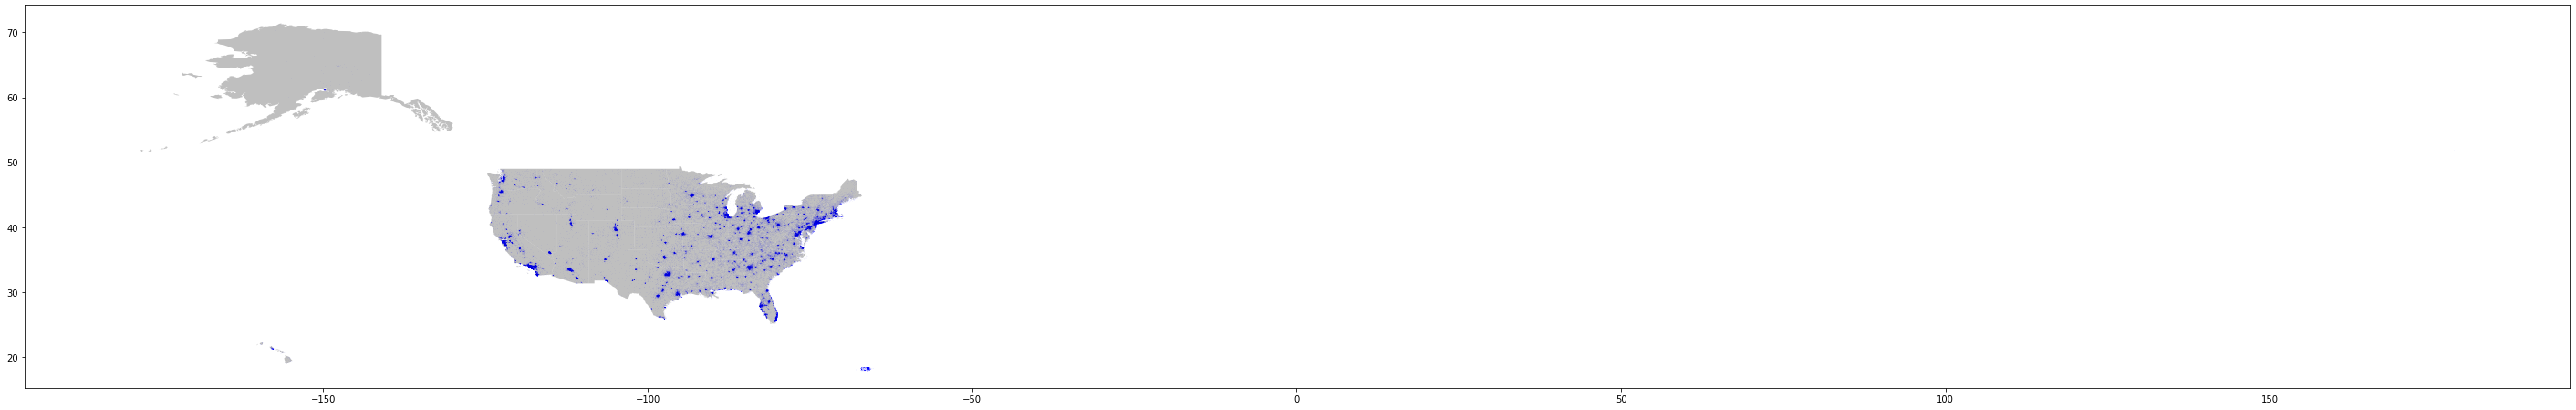

In [234]:
plot_given_cluster_in_map(geo_data_c,-1,0.0001)